In [121]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro
import scipy
from pyts.metrics import dtw
%matplotlib inline


## Assume we have the image

Can't figure out svg,

so I'll assume we have a list of words

Each word is a 120 x 600 (pixel) matrix, gray scale, containing one word


Can be modified, but I'll suppose the images are pre processed correctly
- 0 is black
- 1 is white


In [122]:
list_of_words = []

In [123]:
img = np.array(Image.open("data/output/270/270-01-06.png"),dtype=float)

list_of_words.append(img)

img = np.array(Image.open("data/output/270/270-12-01.png"),dtype=float)

list_of_words.append(img)

img = np.array(Image.open("data/output/270/270-14-02.png"),dtype=float)

list_of_words.append(img)

img
#img.show()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [124]:
test_image = list_of_words[0]

test_image

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

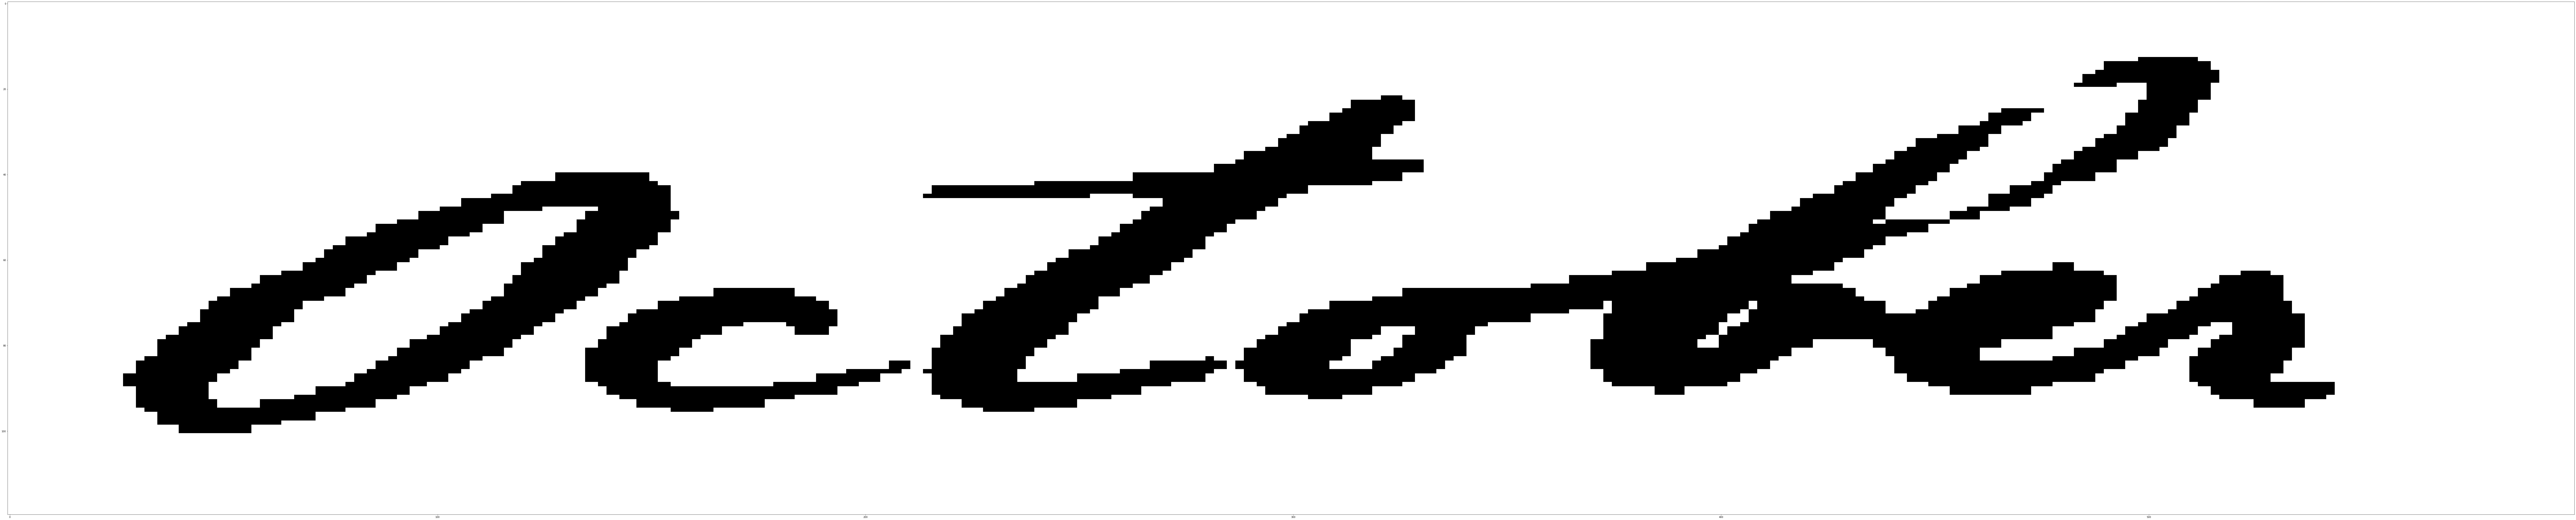

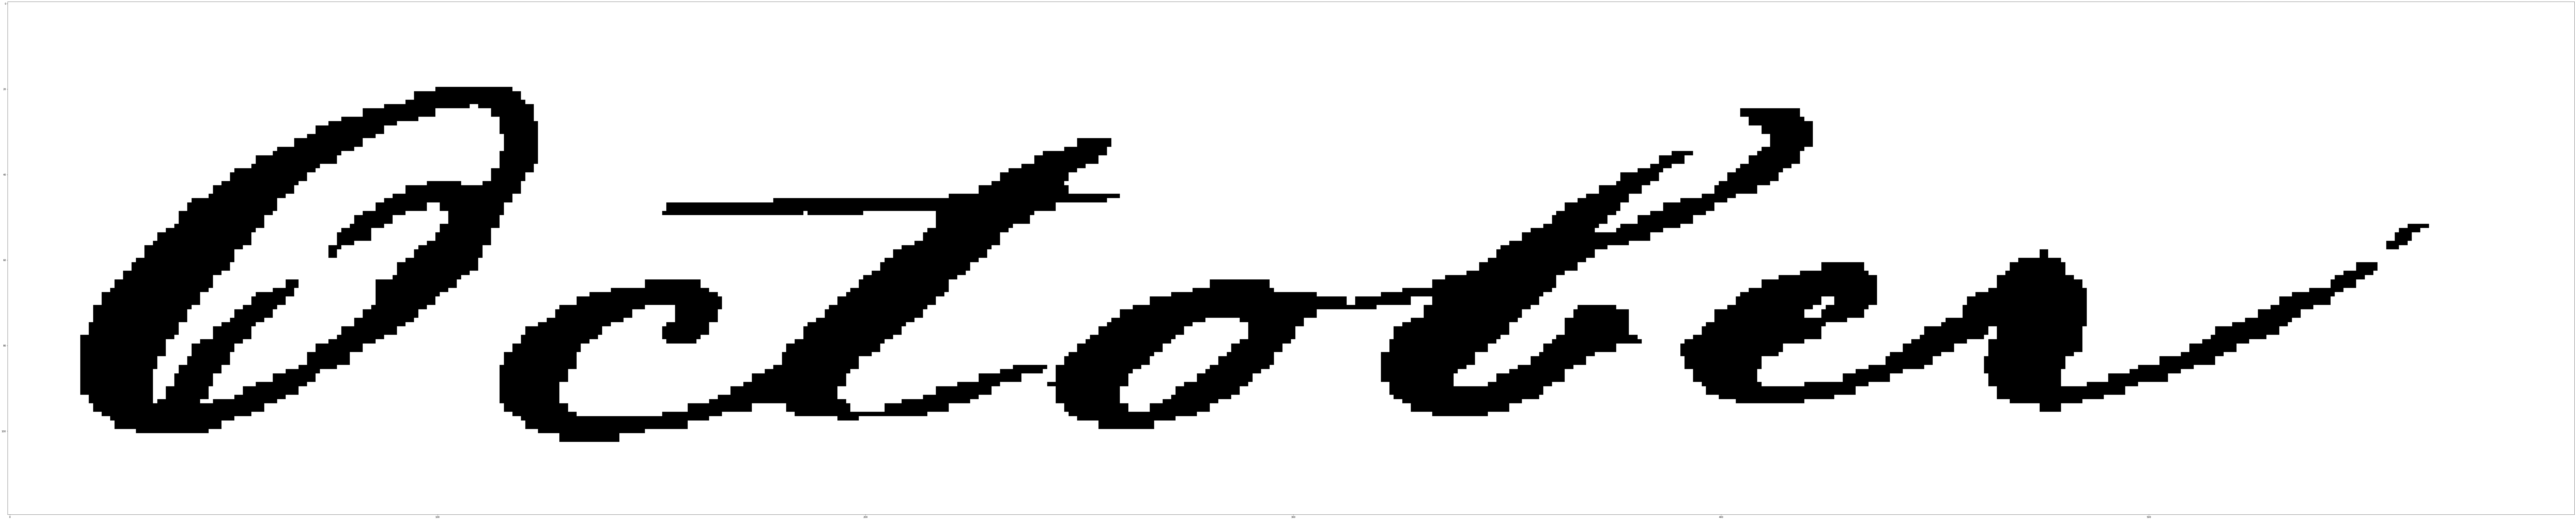

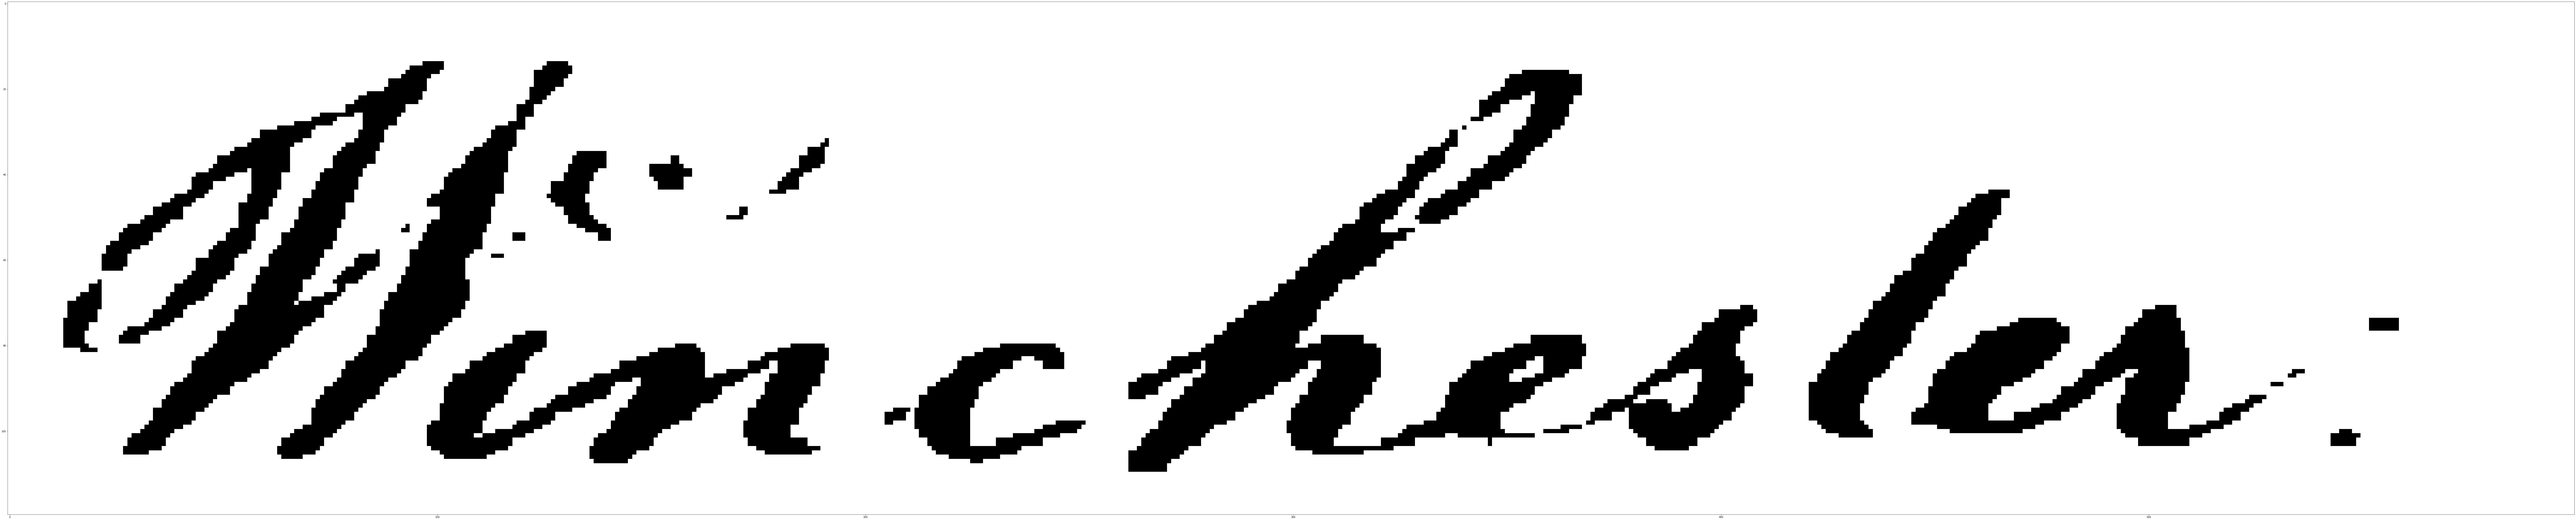

In [125]:

for test_image in list_of_words:    
    plt.figure(figsize=(200,800))
    plt.imshow(test_image,cmap="gray",interpolation="none")
    plt.show()

# Let's imagine this is my word 
# 0 = white and 1 = black

In [126]:
test_slice = test_image[:,0]

test_slice

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

### Features

In [127]:
# features:
#We'll have a sliding 1 pixel band, so slice = 50 x 1

# feature 1
# lower contour

def lower_contour(slice):

    index = np.where(slice <= 0.5)[0]
    
    if len(index) == 0:
        return 0
    else:
        return np.max(index)

# feature 2
# upper contour

def upper_contour(slice):

    index = np.where(slice <= 0.5)[0]
    
    if len(index) == 0:
        return len(slice)
    else:
        return np.min(index)

# feature 3
# fraction of black pixel

def fraction_black(slice):

    number = len(np.where(slice <= 0.5)[0])

    if number == 0:
        return 0.0
    else:
        return number/len(slice)

# feature 4
# fraction of black pixel between the highest and lower contour

def fraction_black_between(slice):

    number = len(np.where(slice <= 0.5)[0])

    

    if number == 0:
        return 0.0
    else:

        index_min = np.min(np.where(slice <= 0.5))
        index_max = np.max(np.where(slice <= 0.5))

        return fraction_black(slice[index_min:index_max+1])

# feature 5
# number of black white transition
def transition_black_white(slice):

    counter = 0
    was_on_black = False

    for i in range(len(slice)):

        if slice[i] <= 0.5 and was_on_black == False:
            was_on_black = True
        
        elif slice[i] > 0.5 and was_on_black == True:
            was_on_black = False
            counter += 1
    
    return counter

number_of_features = 5
    

In [128]:
print(lower_contour(test_slice))
print(upper_contour(test_slice))
print(fraction_black(test_slice))
print(fraction_black_between(test_slice))
print(transition_black_white(test_slice))

0
120
0.0
0.0
0


In [129]:
test_slice_2 = test_image[:,131]


In [134]:
print(lower_contour(test_slice_2))
print(upper_contour(test_slice_2))
print(fraction_black(test_slice_2))
print(fraction_black_between(test_slice_2))
print(transition_black_white(test_slice_2))

95
15
0.18333333333333332
0.2716049382716049
3


### Sliding windows

For a word (120 x 600), compute the equivalent features sequences (5 x 600), for each slice, compute the features points in a R^5 dim space

In [135]:
rep = []
test_image.shape[1]
i = 0
for i in range(test_image.shape[1]):
    
    feature_vector = [lower_contour(test_image[:,i]),upper_contour(test_image[:,i]),fraction_black(test_image[:,i]),fraction_black_between(test_image[:,i]),transition_black_white(test_image[:,i])]
    rep.append(feature_vector)

array = np.asarray(rep)

In [136]:
array 

array([[  0., 120.,   0.,   0.,   0.],
       [  0., 120.,   0.,   0.,   0.],
       [  0., 120.,   0.,   0.,   0.],
       ...,
       [  0., 120.,   0.,   0.,   0.],
       [  0., 120.,   0.,   0.,   0.],
       [  0., 120.,   0.,   0.,   0.]])

In [138]:
pd.DataFrame(array).describe()

,0,1,2,3,4
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,81.665000,69.826667,0.138278,0.553182,1.748333
std,37.273292,32.668466,0.108757,0.360796,1.182085
min,0.000000,14.000000,0.000000,0.000000,0.000000
25%,87.000000,40.000000,0.025000,0.277778,1.000000
50%,99.000000,74.000000,0.133333,0.516282,2.000000
75%,103.000000,90.500000,0.216667,1.000000,3.000000
max,109.000000,120.000000,0.458333,1.000000,5.000000


In [166]:
normed = round(prepro.minmax_scale(array,feature_range=(0,1),axis=0),10)

pd.DataFrame(normed).describe()

TypeError: type numpy.ndarray doesn't define __round__ method

In [167]:
def compute_features_vector(image,normalize=True):

    rep = []
    for i in range(image.shape[1]):
        feature_vector = [lower_contour(image[:,i]),upper_contour(image[:,i]),fraction_black(image[:,i]),fraction_black_between(image[:,i]),transition_black_white(image[:,i])]
        rep.append(feature_vector)
    
    array = np.asarray(rep)

    if normalize:
        array = prepro.minmax_scale(array,feature_range=(0,1),axis=0)
    
    return array
        

In [168]:
octobre_1 = compute_features_vector(list_of_words[0])
octobre_2 = compute_features_vector(list_of_words[1])
winchester = compute_features_vector(list_of_words[2])



In [175]:
octobre_1

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [173]:
octobre_1[0,1]

0.9999999999999999

In [174]:
octobre_2[0,1]

1.0

In [176]:
octobre_1[0,1]-octobre_2[0,1]


-1.1102230246251565e-16

In [181]:
dist_matrix = scipy.spatial.distance.cdist(octobre_2,winchester)
dist_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [182]:
windows_size = 0.5

dtw_cost = dtw(precomputed_cost=dist_matrix,dist="precomputed",method="sakoechiba",options={"window_size":windows_size})

dtw_cost

262.5945152390251

## Test with images...

Need to split an image (for example 270.jpg) into a multiples of scaled 50x200 images containing one word. The file 270.svg contains the path around each word

- load image
- load svg
- for each path in the svg:
    - apply the path to the image
    - remove what is outside, keep inside
    - fill around the path with blank to have the smallest possible box around the word
    - scale the box to a fixed size (50 x 200?)


In [2]:
img = Image.open("data/images/270.jpg").convert("L")

#img.show()

In [3]:
data = np.asarray(img)

data.shape

(3311, 2035)

In [5]:
import svgpathtools as svgt

svg_string="data/ground-truth/locations/270.svg"

In [7]:
paths, attributes = svgt.svg2paths(svg_string)

In [8]:
redpath = paths[0]
redpath_attribs = attributes[0]
print(redpath)
print(redpath_attribs['id'])

Path(Line(start=(112+170j), end=(112+230j)),
     Line(start=(112+230j), end=(129.27+231.5j)),
     Line(start=(129.27+231.5j), end=(132+230j)),
     Line(start=(132+230j), end=(232+230j)),
     Line(start=(232+230j), end=(240+238j)),
     Line(start=(240+238j), end=(299.69+148.25j)),
     Line(start=(299.69+148.25j), end=(192+157j)),
     Line(start=(192+157j), end=(112+170j)))
270-01-01


In [10]:
print(redpath.d())

M 112.0,170.0 L 112.0,230.0 L 129.27,231.5 L 132.0,230.0 L 232.0,230.0 L 240.0,238.0 L 299.69,148.25 L 192.0,157.0 L 112.0,170.0


In [ ]:
url="data/ground-truth/locations/270.svg"

In [7]:
test = svg.svg2png(url="data/ground-truth/locations/270.svg",output_width=img.width,output_height=img.height)

In [1]:
from xml.dom import minidom
from svg.path import parse_path

In [3]:
svg_dom = minidom.parseString(svg_string)

path_strings = [path.getAttribute('d') for path in svg_dom.getElementsByTagName('path')]

for path_string in path_strings:
    path_data = parse_path(path_string)


ExpatError: not well-formed (invalid token): line 1, column 4

In [14]:
file = open("data/ground-truth/locations/270.svg")
svg = file.read()
svg = svg.decode("utf-8")


AttributeError: 'str' object has no attribute 'decode'